 # $\color{red}{\text{Reconstruction du signal audio : TFCT inverse}}$

### Réalisé par :  BENSLIMANE Zahra &  BENAISSA Tarek

#### Introduction :
Dans ce TP, on va dans un premier temps étudier la Transformée de Fourier à court terme inverse, pour cela on utilise la fonction tfct implémentée lors du TP précédent qui nous renvoie la matrice x_mat qui contient la la moitié de la TFD de chaque trame fenêtrée. A partir de cette matrice x_mat on va implémenter la TFCT inverse pour récupérer notre signal échantillonné d’origine, puis discuter en fonction des paramètres choisis les différences entre le signal échantillonné d’origine et le signal échantillonné reconstruit. Dans un second temps, nous allons voir comment débruiter un signal par une soustraction spectrale.


<div class="alert alert-info">


## Préparation :

Soit x[n] un signal audio (réel) discret et xmat sa matrice de TFCT, de dimensions M × L définies au TP2. xmat est calculée à partir des paramètres Nwin, Nhop et Nfft également définis au TP2.

### TFCT inverse

1) l’intérêt de choisir Nwin pair pour le calcul de xmat : 

- pour avoir un nombre de point frequentiel minimal pair et si on prend Nfft = Nwin dans le calcul de la TFCT on on aura une TFD avec longueur paire, et comme on profite de la symetrie Hermitienne, on ne garde que la premiere partie de la TFD de chaque trame, est donc la moitié de Nwin --> donc pour que ça soit possible il faut prenddre un nombre pair



2) l’intérêt de choisir Nfft ≥ Nwin pour le calcul de xmat :

- il faut que le nombre de point en frequence soit au moins egale à la longueur du signal audio, sinon on va perdre des informations, si Nfft< Nwin , on prend pas en compte tout les echantillons temporel mais uniquement Nfft echantillon --> dans ce cas la matrice xmatt ne va pas nous permttre de reconstruire le signal original

- on choisi Nfft ≥ Nwin pour couvrir tout les echantillons du signal

- si on prend Nwin on aura une meilleure resolution frequentielle, courbe plus lisse

3) l’intérêt de choisir Nfft = Nwin (et pas Nfft > Nwin) pour le calcul de xmat ?
- on va pas faire de zero padding, donc on sait exactement combien de valeurs ont été utilisées pour le calcul de la TFD et on pourra facilement calculer la TFCT inverse en calculant la TFDI de meme longueur que la fenetre temporel


- On suppose dans la suite du TP que Nfft = Nwin et que ce paramètre est pair. La lème colonne de xmat est notée [Xl[1]..Xl[M]]T , avec l ∈ [1..L], M représentant le nombre de points fréquentiels utile pour chaque TFD.

4) Montrer que la TFD correspondant à la lème trame fenêtrée de x[n] s’écrit : Xl[1],..,Xl[M],Xl∗[M −1],..,Xl∗[2] où Xl∗[k] désigne le conjugué de Xl[k].

- on a par symetrie hermitienne $ X[M − k] = X^∗[k]$ , $ ∀k ∈ [1.. M] $, donc pour une trame temporel l on a une TFD X_l sur M point frequentiel avec :
$$ M = floor(N_{fft}/2 + 1)$$ 

$$ X[M − (M-1)] = X^∗[M-1]$$  
$$ X[M − (M-2)] = X^∗[M-2]$$
<br/>
          $$.$$
<br/>
           $$.$$
<br/>
           $$.$$
<br/>
$$ X[M − 1] = X^∗[1]$$
<br/>
$$ X[M − 2] = X^∗[2]$$

5) Exprimer la TFD inverse de (Xl[k])k∈[1..Nfft], notée (xl[n])n∈[1..Nwin].


pour $ n \in [0,M-1]$
 $$ x[n] =  \frac{1}{M}  \sum_{k=0}^{M-1} X[k] e^{+2j\pi\frac{k.n}{M}}$$
 
6) A quelle(s) condition(s) sur $(X_l[k]) k∈[1..Nfft]$ la TFD inverse $(x_l[n]) n∈[1..Nwin]$ est-elle réelle?

</div>

### Implémentation de la TFCT inverse par Overlap-Add (OLA)

In [3]:
import wave
from scipy.io import wavfile as wav
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import math
import os


In [4]:
#implémentation de la fonction TFCT  faite lors du tp2
def tfct(audio,nWin,nHop,Nfft):
    #chargement du signal depuis son chemin
    A = (2**15)
    fe,xVect = wav.read(audio)
    xVect = xVect/A
    
    #nombre de trames L
    L = int((len(xVect) - abs(nWin - nHop))//nHop)

    #nombre minimal de points fréquentiels utiles M
    M  = Nfft
    
    #Matrice renvoyé par la fonction
    xMat = np.zeros((M, L),dtype=complex)    
    
    #rempilssage de matrice
    for i in range(L):
        #extraction des trames fenetres
        xVectTrame = xVect[i*nHop: i*nHop + nWin] *np.hamming(nWin)
        #calcul de TF pour chaque trame
        FT = np.fft.fft(xVectTrame,Nfft)
        #remplissage de TF en colonne
        
        xMat[0:int(M/2), i] = FT[0:int(M/2)]
           
    #calcul des vecteurs fréquentiels et temporels
    t = np.linspace(0, len(xVect)/fe, len(xVect))
    f = np.linspace(0, fe, int(Nfft/2))
    #f=np.arange(0,Fe/2,Fe/Nfft)
    return xMat,f,t



###  Implémentation de la TFCT inverse par Overlap-Add (OLA)

1. On veut créer une fonction itf ct.py qui prend en paramètres d’entrée Nhop le pas d’avancement de la fenêtre d’analyse, $N_{fft}$ le nombre de points fréquentiels utilisés pour calculer la T F CT, Fs la fréquence d’échantillonnage et la matrice xmat. Cette fonction renvoie en sortie $y_{vect}$ le signal reconstruit. Ce signal de sortie yvect contient $N_y$ points calculé de la manière suivante :
$$Ny = N_{fft} + (L − 1)N_{hop}$$


2. Ensuite, on veut récupérer les L trames fenêtrées dans le domaine temporel, pour cela on
utilise la matrice xmat qui contient la T F D des L trames fenêtrées dans ces colonnes, puis
on applique la T F D inverse pour récupérer les L trames fenêtrées yl
. Lorsqu’on applique
la T F D inverse numériquement on obtient des valeurs complexes, pour remédier à cela on
va récupérer seulement la partie réelle puisque notre signal xvect est réel, donc on utilise la
fonction np.fft.irfft.


3. Après application de la T F D inverse, on récupère L trames fenêtrées, et on va décaler
chaque yl de lNhop avec l ∈ [0 : L − 1]. Puis on sommer tous les yl décalés, et on récupère
bien yvect à la bonne position.

4. Dernière étape on va normaliser le signal reconstruit yvect par un facteur, parce que lorsqu’on somme les yl on a :



 $$ x[n] = \sum_{l=0}^{L} y_1[n - (l-1) N_{hop}] = x[n] \sum_{n1}^{L} \omega[n - (l-1) N_{hop}] $$

Donc pour récupérer x, on va diviser par K. Le facteur K est calculé de la manière suivante :


 $$ K = \sum_{t=1}^{L} \omega[n - (l-1) N_{hop}]  ~=  \sum_{n=0}^{N_{win}-1} \frac{\omega[n]}{N_{hop}}$$




(égalité lorsque la taille de x est exactement égale à L.Nhop) où w[n] est une fenêtre de
Hamming de taille Nf f t.
On voit avant la normalisation, il y a une différence d’amplitude entre le signal
initial xvect et le signal reconstruit yvect.

In [5]:
# implementation de la fonction itfct pour reconstuire le signal audio à partir de la tfct
def itfct(Nhop,Nfft,Fe,xmat):
    
    L = xmat.shape[1] # le nombre de trames
    
    # pre-allocation de la memoire pour y :
    yvect=np.zeros(Nfft+(L-1)*Nhop) #vecteur pour le signal reconstruit
    
    yl=np.zeros((Nfft,L)) # récupération des L trames fenêtrées 
    
    for i in range(L):
        # generation de la partie symetrique
        col_complete = np.concatenate((xmat[:,i], np.flipud(xmat[:,i])), axis = 0)
        # on applique la TFD inverse pour récupérer les L trames fenêtrées
        yl[:,i]=np.fft.irfft( col_complete,Nfft) 
        # Sommer les trames reconstruites yl à la bonne position de y
        
        yvect[i*Nhop:i*Nhop+Nfft] += yl[:,i] 
        
    hamming=np.hamming(Nfft) # fenêtre de Hamming avec Nfft points

    K=np.sum(hamming)/Nhop 
    yvect/=K    # normaliser par K
    
    t = np.linspace(0,len(yvect)/Fe, len(yvect))  
    
    return yvect , t # retourner le signal reconstruit



In [6]:
# fonction pour tracer le spectrogramme
def spectro(xMat,t,f,fe,title):
    xMat2 = np.zeros(np.shape(xMat))
    for i in range(len(xMat[0])):
        for j in range(len(xMat[:, 0])):
            if xMat[j, i] != 0:
                xMat2[j, i] = 20*np.log10(xMat[j, i])
            else:
                xMat2[j, i] = np.NaN
    plt.figure(figsize=((15,5)))
    plt.imshow(xMat2, aspect='auto',extent =[0,t[-1],0,f[-1]]
               ,interpolation='none', origin='lower',cmap='jet')
    plt.xlabel('temps (s)')
    plt.ylabel("frequence (Hz)")
    plt.ylim(0,fe/2)
    plt.title(title)
    plt.colorbar()
    plt.show()
    



## Realisation :



- Test de l’algorithme sur la matrice xmat calculée par l’algorithme tfct.py, appliqué au fichier audio sound.wav.

In [7]:
# lecture du signal audio
Fe,sound=wav.read('sounds/sound.wav') # Fe: fréquence d'échantillonnage
Te=1/Fe # Te: période d'échantillonnage
N=16 #nombre de bits
x_vect=sound/(2**(N-1)) # charger le signal audio et on divise par 2^(N-1)

In [8]:
display(Audio("sounds/sound.wav"),Fe)

16000

In [10]:

Nwin = 1024
Nhop  = int(Nwin/2) # le pas d'avancement de la fenêtre d'analyse
Nfft  = Nwin # nombre de points fréquentiels

x_mat,f,t=tfct('sounds/sound.wav',Nwin,Nhop,Nfft) # TFCT,les vecteurs fréquentiels et temporels



<div class="alert alert-info">

Discution de la valeur des paramètres utilisés pour la TFCT :

- On choisit les paramètres suivants : Nwin = 1024, Nhop = Nwin/2 et Nfft = Nwin :
- il vaut mieux prendre Nwin pair car on prend aussi Nfft = Nwin, donc pour que la matrice xmat obtenu par tfct contient exactement la moitié des composante de la TFD de chaque trame, 
- on prend Nwin petit et puissanc de 2 pour avoir une bonne resolution temporelle
- on prend Nhop/2 pour respecter la condition pour la reconstruction du signal, il faut que a valeur de K soit indépendant de n, et pour avoir le minimum de chauvauchement entre deux trames successive.
- ceci va nous permettre de bien reconstruire le signal original


affichage du spectogramme réalisé à partir du calcul de la TFCT


C:\Users\zahra\AppData\Local\Temp\ipykernel_5668\2640674175.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  xMat2[j, i] = 20*np.log10(xMat[j, i])


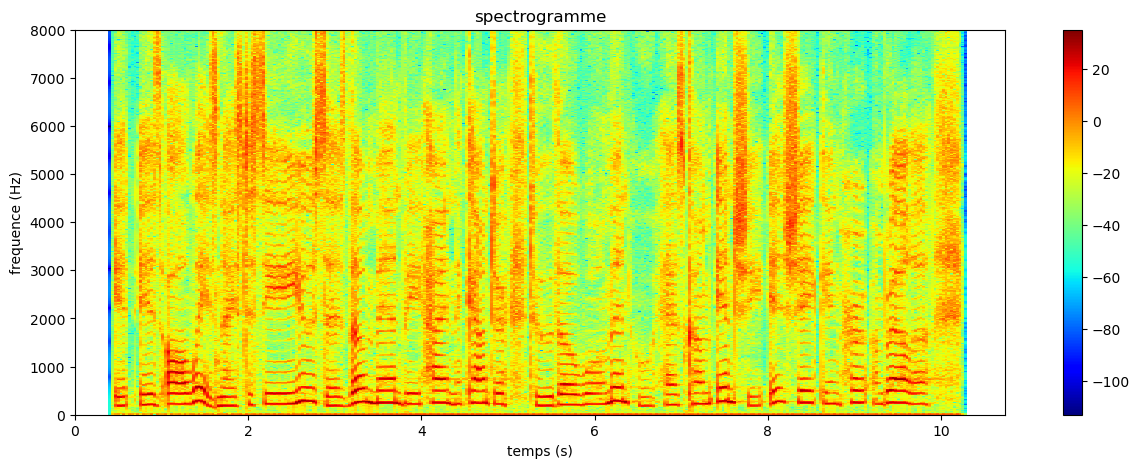

In [11]:
print("affichage du spectogramme réalisé à partir du calcul de la TFCT")
spectro(x_mat,t,f,Fe,"spectrogramme")

In [12]:
# reconstruction du signal et construction du vecteur temporelle correspondant
vect, t = itfct(Nhop,Nfft,Fe,x_mat)

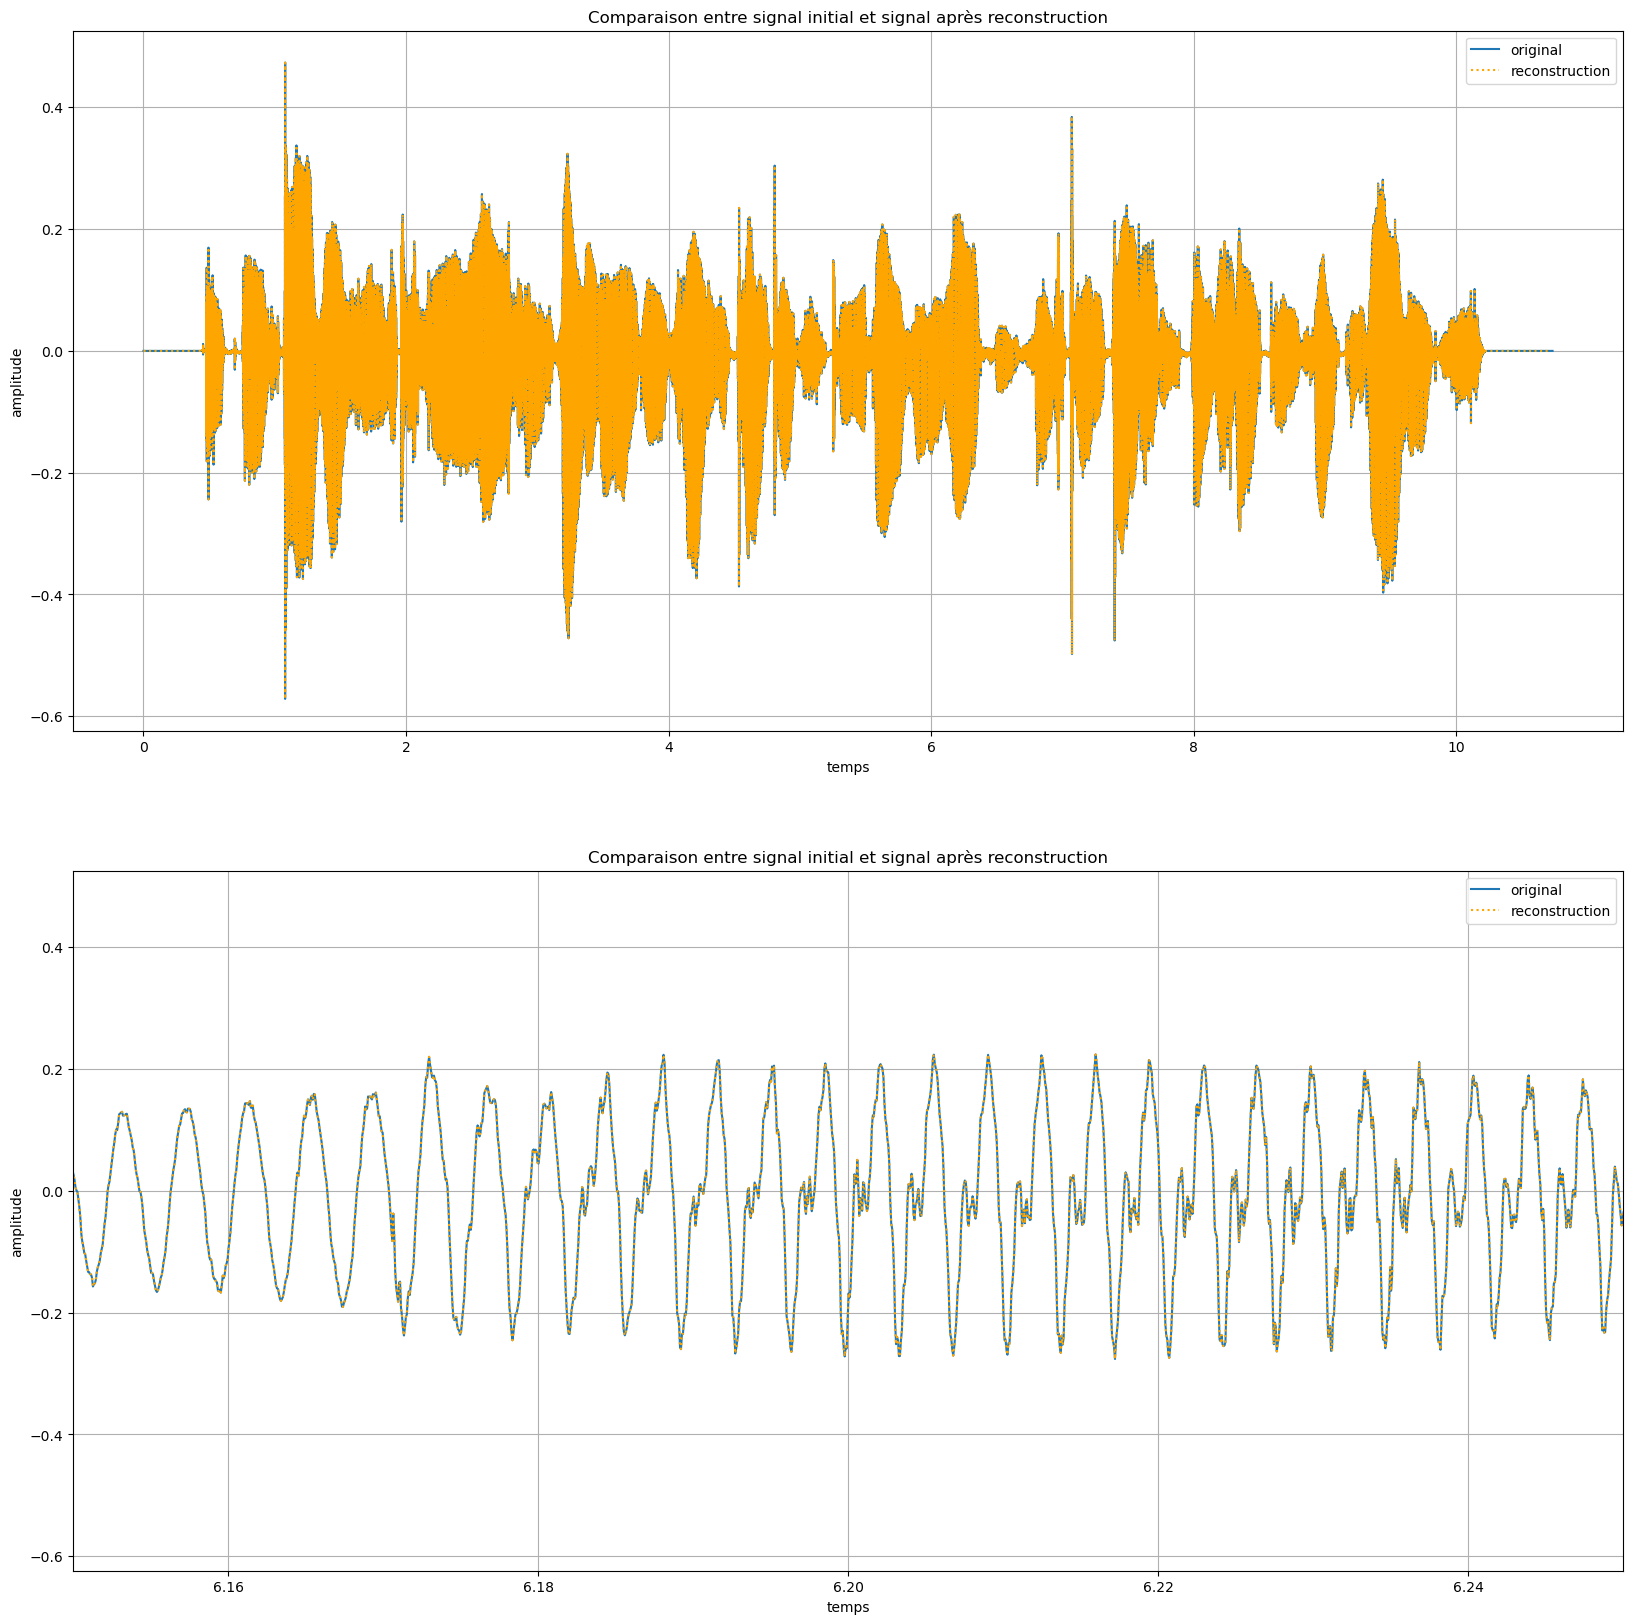

In [13]:
t1 = np.linspace(0,len(sound)/Fe, len(sound))

plt.figure(figsize=(20,20))

plt.subplot(211)
plt.plot(t1,sound/2**15,label='original')
plt.plot(t,vect,':',color='orange',label='reconstruction')
plt.xlabel('temps')
plt.ylabel('amplitude')
plt.title('Comparaison entre signal initial et signal après reconstruction')
plt.legend()
plt.grid()


plt.subplot(212)
plt.plot(t1,sound/2**15,label='original')
plt.plot(t,vect,':',color='orange',label='reconstruction')
plt.xlabel('temps')
plt.xlim((6.150, 6.250))
plt.ylabel('amplitude')
plt.title('Comparaison entre signal initial et signal après reconstruction')
plt.legend()
plt.grid()


# le signal reconstruit est bon

- calcul de l’erreur quadratique entre les deux signaux (original et reconstruit)


In [14]:
# Ecoute du signal
display(Audio(vect,rate= Fe))

# normalisation du signal original
sound = sound / (2**15) 

# Calcul de l'erreur quadratique
erreur_quadratique = (1 /len(vect))*np.sum( (sound[0:len(vect)] - vect)**2 )
print("l'erreur_quadratique = ",erreur_quadratique,", elle est presque nulle")



l'erreur_quadratique =  3.280992093128158e-08 , elle est presque nulle


<div class="alert alert-info">
    
### Remarque : Comparaison du résultat au fichier initial 

- La différence d'amplitude entre le signal original et le signal reconstruit est quasi nulle EQM = 3.28099e-08 , car on a usiliser la TFD pour son inverse que la calculer , les petites erreurs sont dues à la representation du signal dans la mémoire ou il y'a des arrondi ...

-  Aucune distinction entre le signal original et le signal reconstruit par l'oreil humaine.


</div>

### Test du cas ou $ N_{hop} > N_{win}/2$

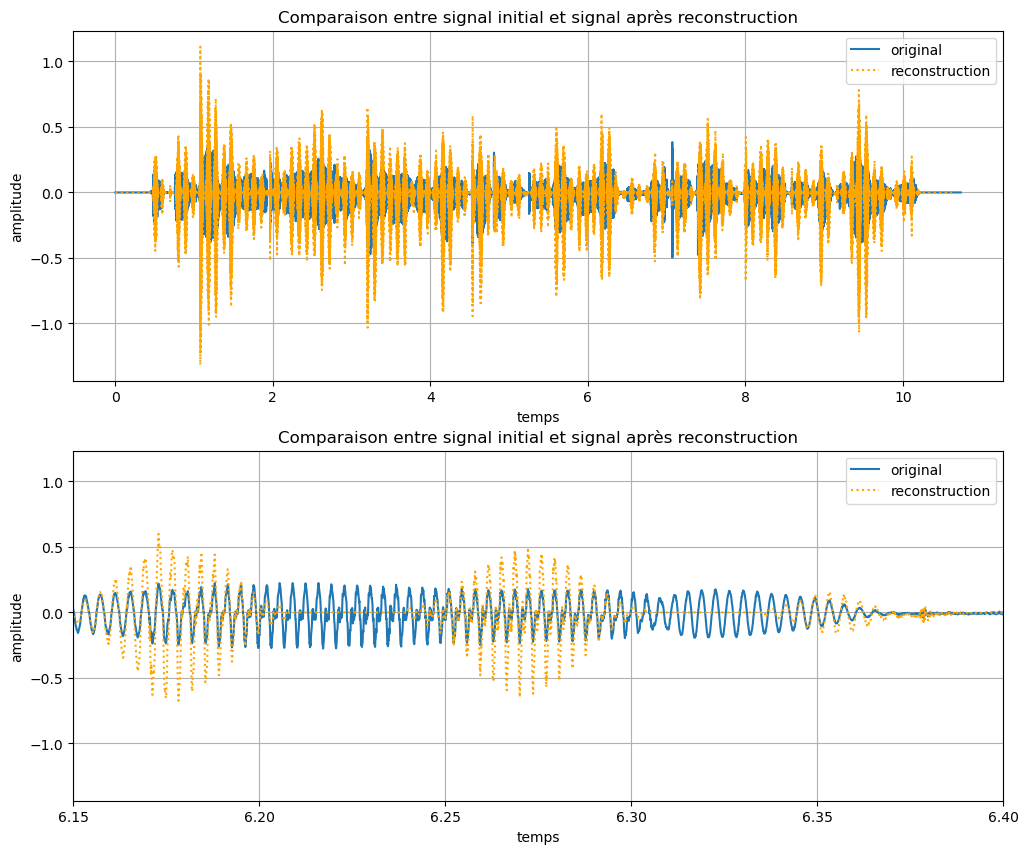

In [15]:
# lecture du signal audio
Fe,sound=wav.read('sounds/sound.wav') # Fe: fréquence d'échantillonnage
Te=1/Fe # Te: période d'échantillonnage
N=16 #nombre de bits
x_vect=sound/(2**(N-1)) # charger le signal audio et on divise par 2^(N-1)

Nwin = 1024
Nhop  = int(Nwin*3/2) # le pas d'avancement de la fenêtre d'analyse
Nfft  = Nwin # nombre de points fréquentiels

x_mat,f,t=tfct('sounds/sound.wav',Nwin,Nhop,Nfft) # TFCT,les vecteurs fréquentiels et temporels

# reconstruction du signal et construction du vecteur temporelle correspondant
vect, t = itfct(Nhop,Nfft,Fe,x_mat)

t1 = np.linspace(0,len(sound)/Fe, len(sound))

plt.figure(figsize=(12,10))

plt.subplot(211)
plt.plot(t1,sound/2**15,label='original')
plt.plot(t,vect,':',color='orange',label='reconstruction')
plt.xlabel('temps')
plt.ylabel('amplitude')
plt.title('Comparaison entre signal initial et signal après reconstruction')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(t1,sound/2**15,label='original')
plt.plot(t,vect,':',color='orange',label='reconstruction')
plt.xlabel('temps')
plt.xlim((6.150, 6.4))
#plt.ylim((-0.7, 0.7))
plt.ylabel('amplitude')
plt.title('Comparaison entre signal initial et signal après reconstruction')
plt.legend()
plt.grid()



In [16]:
# Ecoute du signal
display(Audio(vect,rate= Fe))

# normalisation du signal original
sound = sound / (2**15) 

# Calcul de l'erreur quadratique
erreur_quadratique = (1 /len(vect))*np.sum( (sound[0:len(vect)] - vect)**2 )
print("l'erreur_quadratique = ",erreur_quadratique)

l'erreur_quadratique =  0.004782578633890264


<div class="alert alert-info">
    
### Remarque :

- Le signal reconstruit est largement déformé par rapport au signal original, certain groupes d'échantillons, sont amplifiées, d'autres sont atténués.
    
- L'erreur est relativement grande, sachant que le signal est normalisé entre -1 et 1.
</div>

## Application au débruitage pour soustraction spectrale

Charger le signal audio bruité mix.wav. Calculer et afficher sous forme de spectrogramme la TFCT xmat du signal bruité x à l’aide de l’algorithme implémenté au TP2, en précisant les paramètres Nwin et Nhop choisis.

In [17]:
Fe,mix = wav.read('sounds/mix.wav') 
Te= 1/Fe # Te: période d'échantillonnage
N = 16 #nombre de bits
x_vect = mix/(2**(N-1)) # charger le signal audio et on divise par 2^(N-1)
display(Audio(mix,rate= Fe))

#### Récupération du spectre du bruit
Dans cette partie on considère que le bruit de fond est stationaire, pour débruiter le signal, on trouve le spectre du bruit en lui meme, et pour cela, il faut identifier une zone de silence (pas de parole, juste le bruit de fond). On dessine le spectrogramme du signal mix.wav pour identifier une trame correspondant à cette zone.



---
On choisi les même parametres que précedement pour avoir une bonne resolution temporelle et fréquentielle vu qu'ils nous permis de bien reconstruire le signal dans la première partie 

$$N_{win} = 1024$$
$$N_{hop}  = N_{win}/2$$
$$N_{fft}  = N_{win}$$

C:\Users\zahra\AppData\Local\Temp\ipykernel_5668\2640674175.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  xMat2[j, i] = 20*np.log10(xMat[j, i])


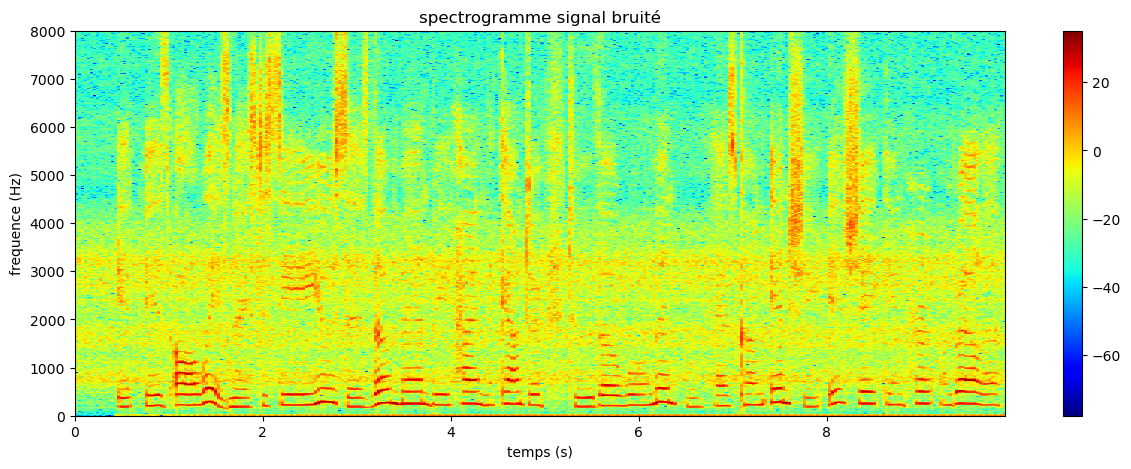

In [19]:
Nwin = 1024
Nhop  = int(Nwin/2) # le pas d'avancement de la fenêtre d'analyse
Nfft  = Nwin # nombre de points fréquentiels
x_mat,f,t=tfct('sounds/mix.wav',Nwin,Nhop,Nfft)

# Tracer du spectrogramme
spectro(x_mat,t,f,Fe,"spectrogramme signal bruité")

<div class="alert alert-info">
    
**Remarque** : D'après le spectrogramme, on peut dire que le silence se trouve dans les premières trames.

</div>

#### Isolation d'une trame contenant que du bruit

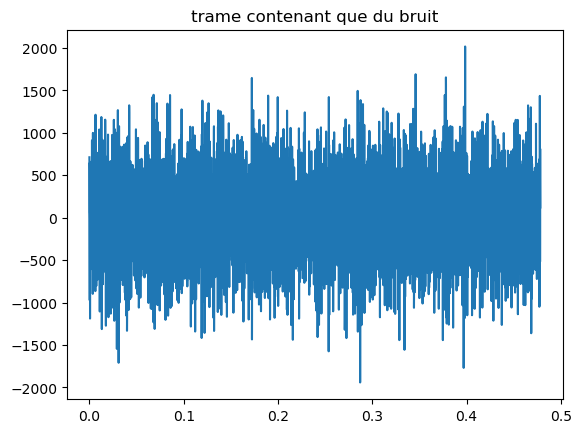

In [20]:
t = np.linspace(0,len(mix)/Fe, len(mix))
plt.plot(t[0:7650], mix[0:7650])
plt.title('trame contenant que du bruit')

# Isolation d'une trame contenant que du bruit
trame_bruit = mix[0:7650]/(2**15)

Te=1/Fe # Te: période d'échantillonnage
N=16 #nombre de bits
display(Audio(trame_bruit,rate= Fe))

#### Calcul du spectre du bruit

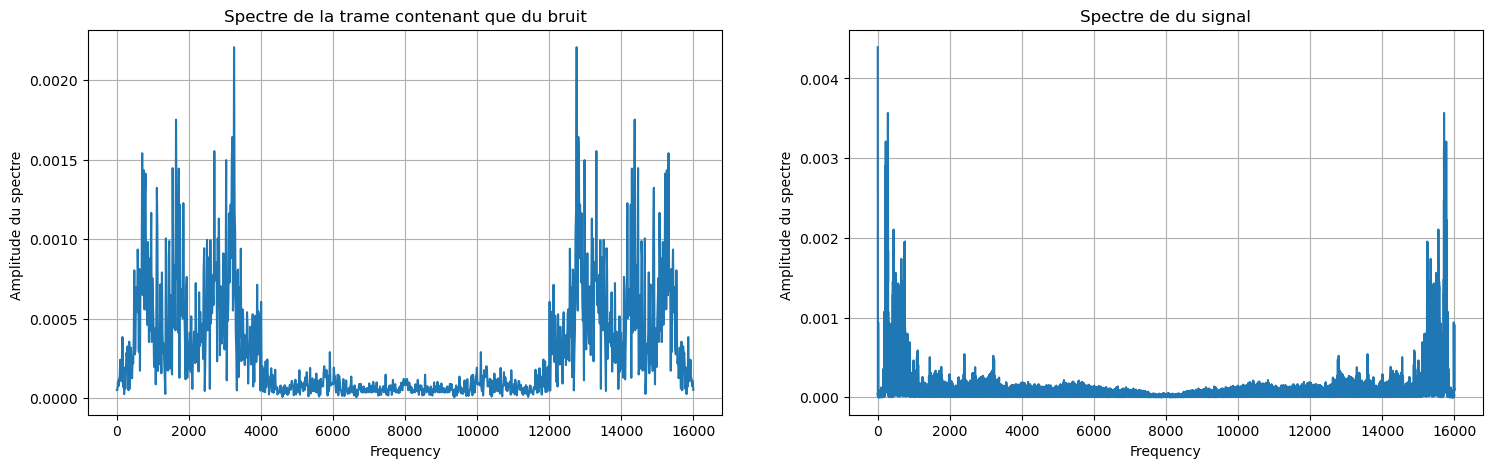

In [22]:
X_noise = np.fft.fft(trame_bruit,Nfft)

Fe,mix = wav.read('sounds/mix.wav') 
TFD_x = np.fft.fft(mix/(2**15),len(mix))

f = np.linspace(0, Fe,len(X_noise))
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(f, np.abs(X_noise)/len(X_noise))
plt.ylabel("Amplitude du spectre ")
plt.title("Spectre de la trame contenant que du bruit")
plt.xlabel("Frequency")
plt.grid(True)

f1 = np.linspace(0, Fe,len(TFD_x))
plt.subplot(1,2,2)
plt.plot(f1, np.abs(TFD_x)/len(TFD_x))
plt.ylabel("Amplitude du spectre ")
plt.title("Spectre de du signal")
plt.xlabel("Frequency")
plt.grid(True)


<div class="alert alert-info">
    
**Commentaire** 
- On a du bruit avec des frequence allant jusqu'à 4000 Hz avec un pic au alentours de 3200 Hz
- L'amplitude du bruit est minime par rapport aux régions ou il y a présence de parole donc il s'agit vraiment d'un bruit

</div>

***
Estimation du spectrogramme du signal débruité $|x_{mat} ^{clean}|$  par soustraction de la signature spectrale du bruit à chaque colonne du module de la TFCT du signal bruité :

 $$|x_{mat} ^{clean}| = |x_{mat}| − |X_{noise}| $$
On tracera et on comparera le spectrogramme avant et après soustraction du spectre de
bruit

In [23]:
X_noise = np.fft.fft(trame_bruit,Nfft)
xclean = np.zeros((x_mat.shape[0], x_mat.shape[1]))

for i in range(x_mat.shape[1]):
    xclean[:,i] = np.abs(x_mat[:,i]) - np.abs(X_noise)
    # effectuer le redressement des valeurs négatives à 0 après soustraction
    for j in range(x_mat.shape[0]):
        if xclean[j,i]<0:
            xclean[j,i]=0
        

C:\Users\zahra\AppData\Local\Temp\ipykernel_5668\2640674175.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  xMat2[j, i] = 20*np.log10(xMat[j, i])


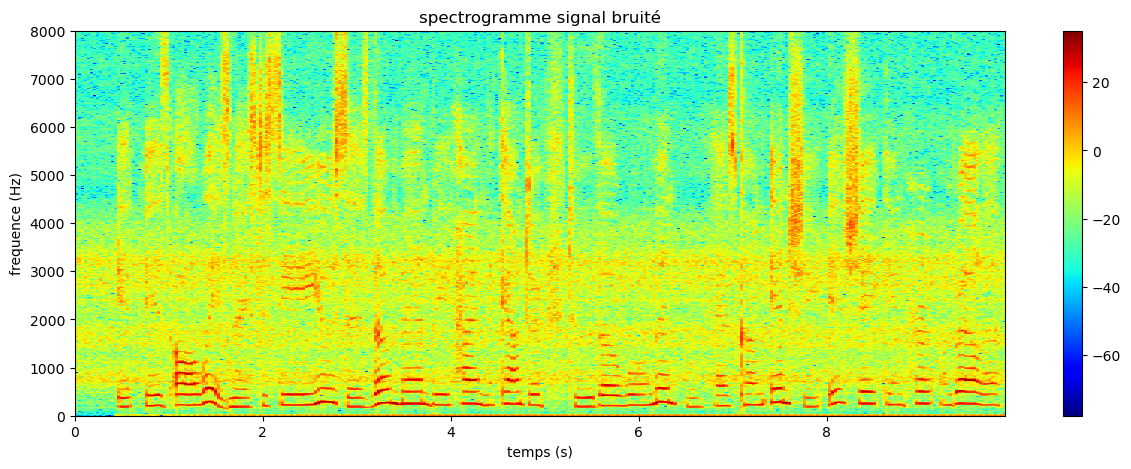

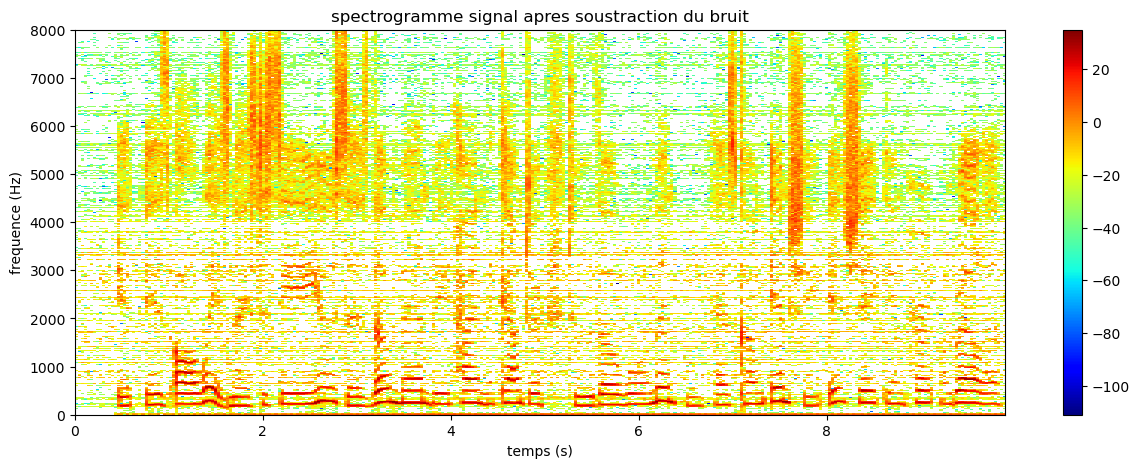

In [24]:
spectro(x_mat,t,f,Fe,"spectrogramme signal bruité")
spectro(xclean,t,f,Fe,"spectrogramme signal apres soustraction du bruit")



<div class="alert alert-info">
    
    
#### Remarque par rapport aux spectrogramme :
On voit qu’il y a une grande différence entre le signal original et le signal reconstruit. On constate qu’on ne peut pas reconstruire le signal à partir de |Xclean|, parce que |Xclean| n’a que des informations sur le module. 
    
#### Explication du redressement des valeurs négatives à 0 :

- Le redressement des valeurs négatives à 0 après soustraction est réalisé car $|x_{mat} ^{clean}|$ est un module et ne peut pas etre négatif.

- On a pris la différence des modules et non pas le module des différences pour éviter de crée des nouvelles informations qui ne correspendent pas à notre audio surtout lors des périodes de silence ou l'amplitude de notre signal est inférieur à celle du bruit, car en réalité le bruit n'est pas stationaire donc cette différence qui est sensée etre négative va devenir  posivite(un bruit de plus), c'est pour cela qu'on les force à 0 et qu'on entend comme des silences.


</div>

In [25]:
# reconstruction du signal et construction du vecteur temporelle correspondant
vect_clean, t = itfct(Nhop,Nfft,Fe,xclean)

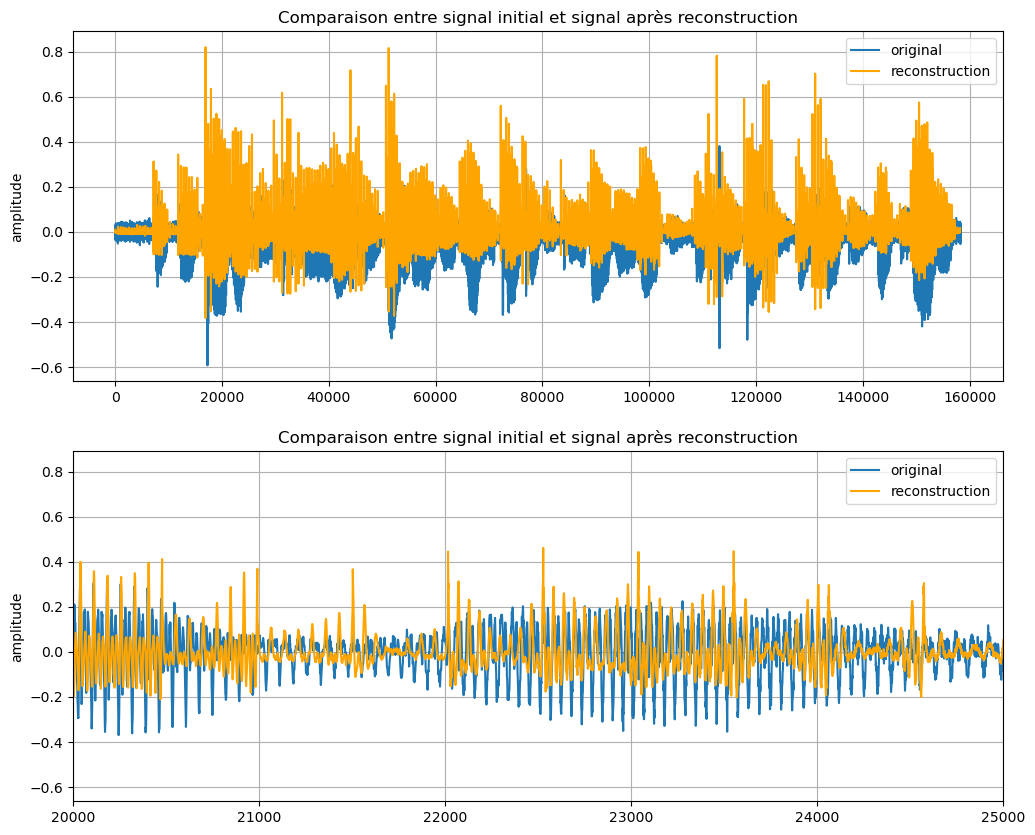

In [26]:

t1 = np.linspace(0,len(sound)/Fe, len(mix))

plt.figure(figsize=(12,10))

plt.subplot(211)
plt.plot(mix/2**15,label='original')
plt.plot(vect_clean,color='orange',label='reconstruction')
plt.ylabel('amplitude')
plt.title('Comparaison entre signal initial et signal après reconstruction')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(mix/2**15,label='original')
plt.plot(vect_clean,color='orange',label='reconstruction')
plt.xlim((20000, 25000))
#plt.ylim((-0.7, 0.7))
plt.ylabel('amplitude')
plt.title('Comparaison entre signal initial et signal après reconstruction')
plt.legend()
plt.grid()






<div class="alert alert-info">
    
- On zoom sur le signal, on voit que le signal débruité est deformé et déphasé par rapport au signal original. Et la partie négative du signal est moins important que le signal original tandis que la partie positive est un peu amplifiée


</div>

 #### on écoute le son débruité.

In [27]:
display(Audio(vect_clean,rate= Fe))


 
 <div class="alert alert-info">
    
 #### Remarque : 
 - le son débruité est de très mauvaise qualité.
</div>

## Reconstruction du signal audio débruité à partir du spectre complexe :

In [28]:
xclean_b = np.abs(xclean)*np.exp(1j*np.angle(x_mat))

In [29]:
vect_cleanB, t = itfct(Nhop,Nfft,Fe,xclean_b)


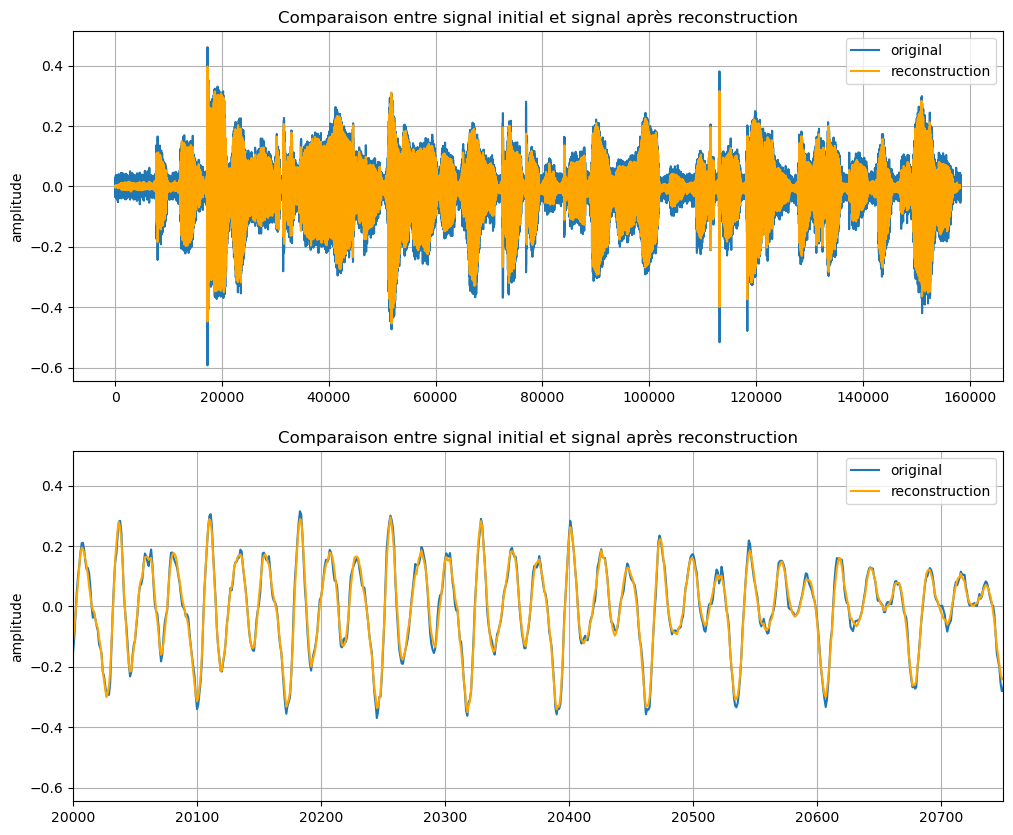

In [30]:
t1 = np.linspace(0,len(sound)/Fe, len(mix))

plt.figure(figsize=(12,10))

plt.subplot(211)
plt.plot(mix/2**15,label='original')
plt.plot(vect_cleanB,color='orange',label='reconstruction')
plt.ylabel('amplitude')
plt.title('Comparaison entre signal initial et signal après reconstruction')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(mix/2**15,label='original')
plt.plot(vect_cleanB,color='orange',label='reconstruction')
plt.xlim((20000, 20750))
#plt.ylim((-0.7, 0.7))
plt.ylabel('amplitude')
plt.title('Comparaison entre signal initial et signal après reconstruction')
plt.legend()
plt.grid()




<div class="alert alert-info">
    
- Cette fois-ci, on a l’information sur le module et la phase. on voit que le signal débruité est assez proche du signal d’origine. Donc la reconstruction du signal après la suppression du bruit est bonne. 


- On zoome sur le signal, on peut voir que le signal débruité (courbe en orange) est bien en phase avec le signal original (courbe en bleu). Mais il reste toujours du bruit dans le signal débruité.

</div>

In [31]:
display(Audio(vect_cleanB,rate= Fe))



<div class="alert alert-info">
    
- On écoute ce son débruité, la qualité est mieux que celui précédent, mais il y a toujours du bruit. Le volume du bruit dans le son débruité est plus petit que celui du son mix, donc ce débruitage a diminué les bruits.
    
- Ce débruitage n’est pas  parfait  car on n’a pas pu supprimé totalement les bruits.

#### Les raisons qu’on ne peut pas avoir un débruitage parfait :
    
- Première raison : on a pris une trame comme bruit du fond en supposant que le bruit est stationnaire, mais ce n'est pas forcément le cas.
    
- Deuxième raison : on a |Xclean +Xnoise| = |Xmix|, alors |Xclean|+|Xnoise| ≥ |Xmix| d’après l’inégalité triangulaire. Mais on a fait une approximation |Xclean| + |Xnoise| = |Xmix|.

</div>

## Conclusion :
- Dans ce TP, on a implémenté la fonction TFCT inverse par la méthode Overlap-Add (OLA) pour reconstruire le signal audio, puis on a débruité le signal par une soustraction spectrale.

- La fonction TFCT inverse permet de reconstruire le signal audio à partir de sa TFCT. Pour bien reconstruire le signal les paramètres Nwin et Nhop sont importants. Si Nhop > Nwin/2 , on ne peut pas reconstruire le signal.

- Le débruitage consiste à utiliser à la fois la TFCT et la TFCT inverse. Il faut d’abord appliquer la TFCT sur le signal bruité, et observer son spectrogramme obtenu par la TFCT pour trouver une zone de silence qui ne contient que du bruit. par la suite il faut soustraire le bruit, et applique la TFCT inverse pour obtenir le signal débruité. 

- Quand on fait la soustraction spectrale, on doit aussi ajouter l’information sur la phase. Mais ce débruitage n’est pas parfait suite aux approximations qui ont été faites.